In [75]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [76]:
import sys

ABSOLUTE_PATH = "/content/drive/My Drive/deepfake_tweets"
PREPROCESSED_DATA_DIR = ABSOLUTE_PATH + "/data/preprocessed"
EXPORT_MODEL_DIR = ABSOLUTE_PATH + "/models/baseline"

sys.path.insert(0, ABSOLUTE_PATH)

# Building BERT baseline results

In [77]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import DataLoader, Dataset
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    TrainingArguments,
    Trainer,
)
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

from utils import TweetDataset, compute_metrics, plot_confusion_matrix

In [78]:
# Import preprocessed dataset splits
train_df, val_df, test_df = (
    pd.read_csv(os.path.join(PREPROCESSED_DATA_DIR, "tweepfake_train.csv")),
    pd.read_csv(os.path.join(PREPROCESSED_DATA_DIR, "tweepfake_val.csv")),
    pd.read_csv(os.path.join(PREPROCESSED_DATA_DIR, "tweepfake_test.csv"))
)

## Loading tokenizer and model

In [79]:
MODEL_NAME = "bert-base-cased"
NUM_LABELS = 2
BATCH_SIZE = 32

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    # output_attentions=False,
    # output_hidden_states=False
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [80]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = model.to(device)

### Preparing dataset for testing

In [81]:
label_mapping = { 0: "human", 1: "bot" }

X_test = test_df['text'].values
y_test = (test_df['account.type'] == 'bot').astype(int).values

test_dataset = TweetDataset(X_test, y_test, tokenizer)

## Model inference

In [82]:
args = TrainingArguments(
    output_dir=EXPORT_MODEL_DIR,
    report_to=["tensorboard"]
)

trainer = Trainer(
    model=model,
    args=args,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

<ipython-input-82-d05125b83c44>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


### Evaluate results

In [83]:
# eval_results = trainer.evaluate(test_dataset)
# eval_results

In [84]:
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)

In [85]:
print(classification_report(y_test, predicted_labels))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1278
           1       0.50      1.00      0.67      1280

    accuracy                           0.50      2558
   macro avg       0.25      0.50      0.33      2558
weighted avg       0.25      0.50      0.33      2558



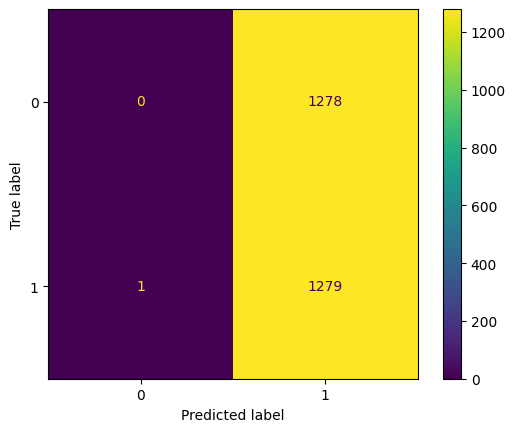

In [86]:
plot_confusion_matrix(y_test, predicted_labels)

In [87]:
y_test = np.array([label_mapping[label] for label in y_test])
predicted_labels = np.array([label_mapping[label] for label in predicted_labels])

print(classification_report(y_test, predicted_labels))

              precision    recall  f1-score   support

         bot       0.50      1.00      0.67      1280
       human       0.00      0.00      0.00      1278

    accuracy                           0.50      2558
   macro avg       0.25      0.50      0.33      2558
weighted avg       0.25      0.50      0.33      2558

